**Updates Nov 10th, 2018**
* OpenSlide can now be installed in Colab.
* A folder containing example slides and tumor masks is linked below. These should be sufficient for your project. The goal is to build a working end-to-end prototype, not to match the accuracy from the papers (or to train on a giant amount of data).


---


Below is an example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 

* You can find a folder of slides and tumor masks [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 22 slides and tissue masks. The tissue masks were produced using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP (it has a variety of dependencies, depending on your OS). This way, you'll only need to install OpenSlide.

* This amount of data should be more than sufficient for our project. (If you'd like to work with more, you will need to produce tissue masks yourself using ASAP). 


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`. You will need install open slide on your computer, and run this notebook locally for that to work.







In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libcairo2 libgdk-pixbuf2.0-0 libgdk-pixbuf2.0-bin libgdk-pixbuf2.0-common
  libjbig0 libopenjp2-7 libopenslide0 libpixman-1-0 libtiff5 libxcb-render0
  libxcb-shm0 shared-mime-info
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libcairo2 libgdk-pixbuf2.0-0 libgdk-pixbuf2.0-bin libgdk-pixbuf2.0-common
  libjbig0 libopenjp2-7 libopenslide0 libpixman-1-0 libtiff5 libxcb-render0
  libxcb-shm0 openslide-tools shared-mime-info
0 upgraded, 13 newly installed, 0 to remove and 8 not upgraded.
Need to get 1,849 kB of archives.
After this operation, 6,727 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 shared-mime-info amd64 1.9-2 [426 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpixman-1-0 amd64 0.34.0-2 [229 kB]
Get:3 http://archive.ubuntu.c

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import cv2
import tensorflow as tf
#tf.enable_eager_execution()
tf.VERSION


'1.12.0'

In [3]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  71.1M      0  0:00:07  0:00:07 --:--:-- 88.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  32.2M      0 --:--:-- --:--:-- --:--:-- 32.2M


In [4]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)): # in total 7 levels zoom
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
('Slide includes %d levels', 8)
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

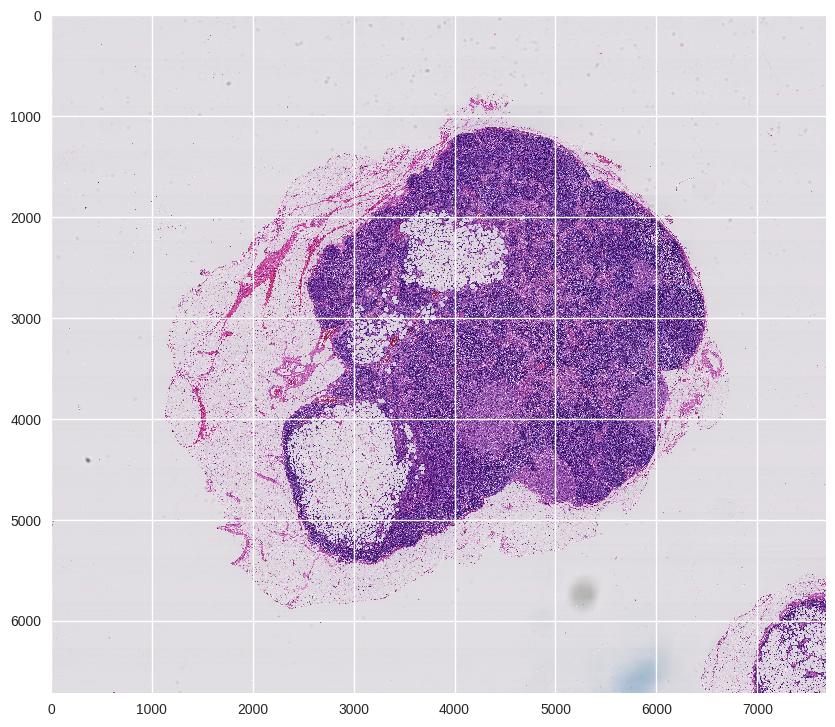

In [6]:
# Example: read the entire slide at level 5

# High zoom levels may not fit into memory.
# That's why we use OpenSlide. You can use the below function
# to extract regions from high zoom levels without having to 
# read the entire image.

# Note: this is just for demo purposes. 

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to see if same region on the mask image contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=3, 
                         width=slide.level_dimensions[3][0], 
                         height=slide.level_dimensions[3][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

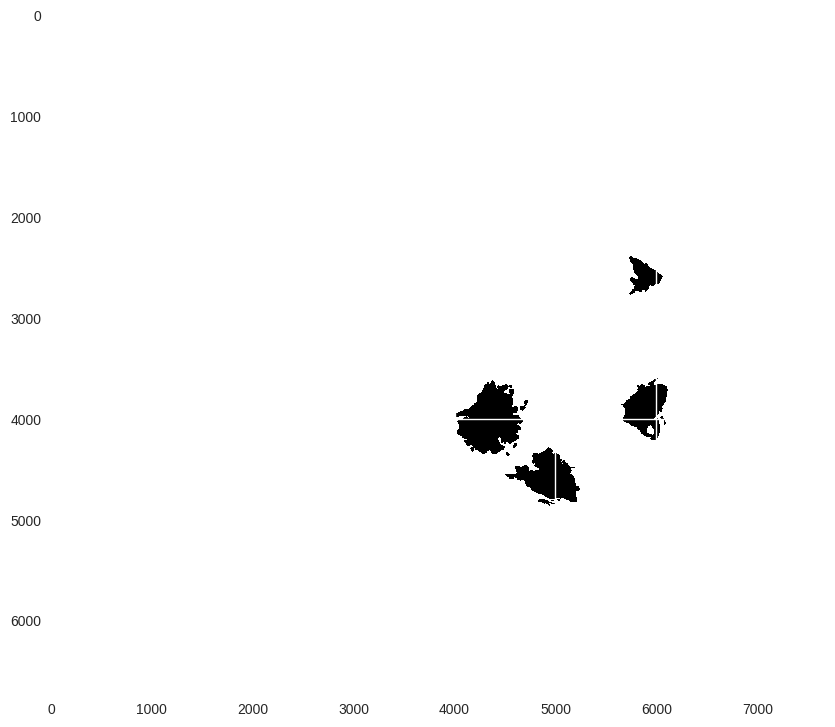

In [7]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=3, 
                        width=slide.level_dimensions[3][0], 
                        height=slide.level_dimensions[3][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]
#print(mask_image.shape)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

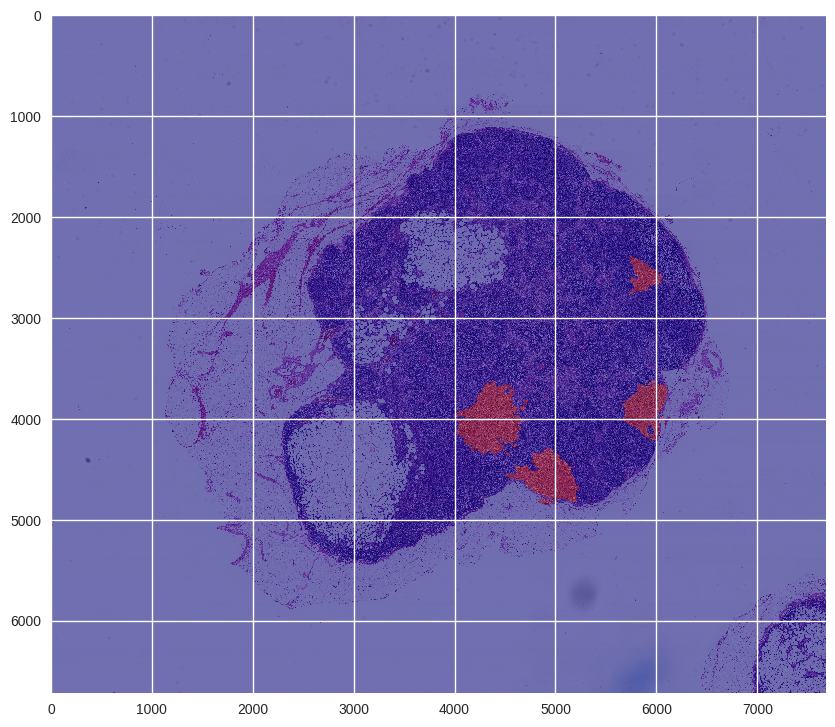

In [8]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

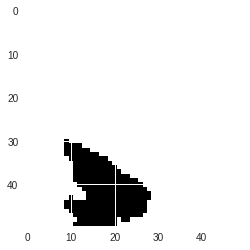

In [9]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

In [0]:
(w_width, w_height) = (224, 224)

def sliding_window(image, stepSize=224, windowSize=(w_width, w_height)):
	# slide a window across the image
	for x in range(0, image.shape[0]-w_width, stepSize):
		for y in range(0, image.shape[1]-w_height, stepSize):
			# yield the current window
			yield (x, y), image[x:x + w_width, y:y + w_height]

In [11]:
X_indices, X_patches = zip(*sliding_window(slide_image))

X_patches = np.array([patch for patch in X_patches])
assert X_patches.shape[0] == len(X_indices)
print(X_patches.shape)


(986, 224, 224, 3)


In [0]:
# import cv2
# # draw rectangle on image
# cv2.rectangle(slide_image, (x, y), (x + w_width, y + w_height), (255, 0, 0), 2) 
# plt.imshow(np.array(slide_image).astype('uint8'))

In [13]:
import math
y_indices, y_patches = zip(*sliding_window(mask_image))
y_patches = np.array([math.ceil(np.mean(patch)) for patch in y_patches])
print(y_patches.shape)

(986,)


# Undersampling on the negative class
The object recognition problem has been transformed into an imbalanced classification problem. Before splitting the dataset into training and test, we want to undersample the positive class in order to balance the classes. 

In [14]:
majority_indices = np.where(y_patches==0)[0]
minority_count = (y_patches==1).sum()
print(minority_count)
print(len(majority_indices))

40
946


In [0]:
#undersampling
sample_indices = np.random.choice(majority_indices, size=minority_count, replace=False)
X_sample = np.append(X_patches[sample_indices], X_patches[np.where(y_patches==1)], axis=0)
y_sample = np.append(y_patches[sample_indices], y_patches[np.where(y_patches==1)])

In [0]:
# shuffling 
new_indices = np.arange(X_sample.shape[0])
#print(new_indices)
np.random.shuffle(new_indices)
#print(new_indices)
X_sample = X_sample[new_indices]
y_sample = y_sample[new_indices]

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2)

In [18]:
print(y_train.shape, y_test.shape)
(y_test==1).sum()

((64,), (16,))


6

# Model Baseline

In [19]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                  include_top=False, input_shape=(224, 224, 3))
conv_base.trainable = False
#conv_base.summary()

58900480/58889256 [==============================] - 3s 0us/step


In [20]:
model = tf.keras.Sequential([
  conv_base,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')])

model.compile(optimizer = tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 14,731,170
Trainable params: 16,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Train on 57 samples, validate on 7 samples
Epoch 1/10
57/57 [==============================] - 10s 169ms/step - loss: 2.4391 - acc: 0.4386 - val_loss: 1.7920 - val_acc: 0.2857
Epoch 2/10
57/57 [==============================] - 1s 11ms/step - loss: 0.7243 - acc: 0.8070 - val_loss: 2.6913 - val_acc: 0.4286
Epoch 3/10
57/57 [==============================] - 1s 11ms/step - loss: 1.0109 - acc: 0.8070 - val_loss: 2.6915 - val_acc: 0.4286
Epoch 4/10
57/57 [==============================] - 1s 11ms/step - loss: 0.8474 - acc: 0.8421 - val_loss: 2.1307 - val_acc: 0.5714
Epoch 5/10
57/57 [==============================] - 1s 11ms/step - loss: 0.5230 - acc: 0.8772 - val_loss: 1.3235 - val_acc: 0.7143
Epoch 6/10
57/57 [==============================] - 1s 11ms/step - loss: 0.3035 - acc: 0.9298 - val_loss: 0.6341 - val_acc: 0.7143
Epoch 7/10
57/57 [==============================] - 1s 11ms/step - loss: 0.2625 - acc: 0.8772 - val_loss: 0.3612 - val_acc: 0.8571
Epoch 8/10
57/57 [====================

In [22]:
scores = model.evaluate(X_test, y_test)

print 'Loss: ', scores[0]
print'Accuracy: ', scores[1]

16/16 [==============================] - 2s 102ms/step
Loss:  0.26818662881851196
Accuracy:  0.875


In [0]:
y_predict = model.predict(X_test)
y_predict_label = y_predict.argmax(axis=1)

In [24]:
y_predict_label.mean()

0.5

In [25]:
y_predict_label[:30]

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0])

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

print 'Precision:', precision_score(y_test, y_predict_label)
print 'Recall:', recall_score(y_test, y_predict_label)
print 'F1:', f1_score(y_test, y_predict_label)

Precision: 0.75
Recall: 1.0
F1: 0.8571428571428571


# Oversampling on the postive class
For comparison.

In [27]:
minority_indices = np.where(y_patches==1)[0]
majority_count = (y_patches==0).sum()
print(majority_count)
print(len(minority_indices))

946
40


In [0]:
#oversampling
sample_indices = np.random.choice(minority_indices, size=majority_count, replace=True)
X_sample = np.append(X_patches[sample_indices], X_patches[np.where(y_patches==0)], axis=0)
y_sample = np.append(y_patches[sample_indices], y_patches[np.where(y_patches==0)])

In [0]:
# shuffling 
new_indices = np.arange(X_sample.shape[0])
#print(new_indices)
np.random.shuffle(new_indices)
#print(new_indices)
X_sample = X_sample[new_indices]
y_sample = y_sample[new_indices]

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2)

In [31]:
print(y_train.shape, y_test.shape)
(y_test==1).sum()

((1513,), (379,))


191

In [32]:
model_ = tf.keras.Sequential([
  conv_base,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')])

model_.compile(optimizer = tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['acc'])
model_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 14,731,170
Trainable params: 16,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [33]:
model_.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Train on 1361 samples, validate on 152 samples
Epoch 1/10
1361/1361 [==============================] - 17s 13ms/step - loss: 0.4232 - acc: 0.8589 - val_loss: 0.2296 - val_acc: 0.9211
Epoch 2/10
1361/1361 [==============================] - 13s 10ms/step - loss: 0.1240 - acc: 0.9574 - val_loss: 0.1258 - val_acc: 0.9605
Epoch 3/10
1361/1361 [==============================] - 13s 10ms/step - loss: 0.0883 - acc: 0.9721 - val_loss: 0.1354 - val_acc: 0.9474
Epoch 4/10
1361/1361 [==============================] - 13s 10ms/step - loss: 0.0622 - acc: 0.9794 - val_loss: 0.0911 - val_acc: 0.9605
Epoch 5/10
1361/1361 [==============================] - 13s 10ms/step - loss: 0.0579 - acc: 0.9802 - val_loss: 0.0679 - val_acc: 0.9605
Epoch 6/10
1361/1361 [==============================] - 13s 10ms/step - loss: 0.0365 - acc: 0.9890 - val_loss: 0.0844 - val_acc: 0.9605
Epoch 7/10
1361/1361 [==============================] - 13s 10ms/step - loss: 0.0257 - acc: 0.9927 - val_loss: 0.0374 - val_acc: 0.9868
E

In [34]:
scores = model_.evaluate(X_test, y_test)

print 'Loss: ', scores[0]
print'Accuracy: ', scores[1]

379/379 [==============================] - 6s 15ms/step
Loss:  0.04199743083135119
Accuracy:  0.9762532997257162


In [35]:
y_predict = model_.predict(X_test)
y_predict_label = y_predict.argmax(axis=1)

print 'Precision:', precision_score(y_test, y_predict_label)
print 'Recall:', recall_score(y_test, y_predict_label)
print 'F1:', f1_score(y_test, y_predict_label)

Precision: 0.955
Recall: 1.0
F1: 0.9769820971867007


Oversampling seems to perform slightly better. 

13344403 tissue_pixels pixels (29.6 percent of the image)


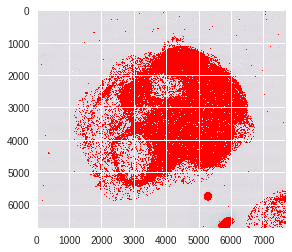

In [36]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [37]:
tissue_regions.shape

(6720, 7680, 3)

In [38]:
tissue_regions[0][0]

array([222, 220, 225], dtype=uint8)

In [0]:
# (w_width, w_height) = (224, 224)

# def sliding_region(image, stepSize=224, windowSize=(w_width, w_height)):
# 	# slide a window across the image
# 	for x in range(0, image.shape[0]-w_width, stepSize):
# 		for y in range(0, image.shape[1]-w_height, stepSize):
# 			# yield the current window
# 			for i in range(x, x+w_width):
# 				for j in range(y, y+w_height):
# 					if image[i][j] == (255,0,0):
# 			yield image[x:x + w_width, y:y + w_height]

In [0]:
# X_patches = zip(*sliding_region(tissue_regions))

# X_patches = np.array([patch for patch in X_patches])

# print(X_patches.shape)
# (986, 224, 224, 3)

In [41]:
X_region = []
y_region = []
for idx, (x, y) in enumerate(X_indices):
  img = X_patches[idx]
  for i in range(x, x+img.shape[0]):
    for j in range(y, y+img.shape[1]):
      
      if (tissue_regions[i][j] == np.array([255,0,0])).all():
        X_region.append(img)
        y_region.append(y_patches[idx])
        break
    else:
      continue
    break
  
X_region = np.array(X_region)
y_region = np.array(y_region)

print(X_region.shape, y_region.shape)     

((941, 224, 224, 3), (941,))


In [42]:
minority_indices = np.where(y_region==1)[0]
majority_count = (y_region==0).sum()
print(majority_count)
print(len(minority_indices))

901
40


In [0]:
#oversampling
sample_indices = np.random.choice(minority_indices, size=majority_count, replace=True)
X_sample = np.append(X_region[sample_indices], X_region[np.where(y_region==0)], axis=0)
y_sample = np.append(y_region[sample_indices], y_region[np.where(y_region==0)])

In [0]:
# shuffling 
new_indices = np.arange(X_sample.shape[0])
#print(new_indices)
np.random.shuffle(new_indices)
#print(new_indices)
X_sample = X_sample[new_indices]
y_sample = y_sample[new_indices]

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2)

In [46]:
print(y_train.shape, y_test.shape)
(y_test==1).sum()

((1441,), (361,))


183

In [47]:
model_ = tf.keras.Sequential([
  conv_base,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')])

model_.compile(optimizer = tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['acc'])
model_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 14,731,170
Trainable params: 16,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [48]:
model_.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Train on 1296 samples, validate on 145 samples
Epoch 1/10
1296/1296 [==============================] - 13s 10ms/step - loss: 0.3398 - acc: 0.8673 - val_loss: 0.1186 - val_acc: 0.9586
Epoch 2/10
1296/1296 [==============================] - 13s 10ms/step - loss: 0.1360 - acc: 0.9491 - val_loss: 0.0685 - val_acc: 0.9724
Epoch 3/10
1296/1296 [==============================] - 13s 10ms/step - loss: 0.0960 - acc: 0.9637 - val_loss: 0.0476 - val_acc: 0.9862
Epoch 4/10
1296/1296 [==============================] - 13s 10ms/step - loss: 0.0761 - acc: 0.9769 - val_loss: 0.0334 - val_acc: 0.9862
Epoch 5/10
1296/1296 [==============================] - 13s 10ms/step - loss: 0.0582 - acc: 0.9792 - val_loss: 0.0388 - val_acc: 0.9931
Epoch 6/10
1296/1296 [==============================] - 13s 10ms/step - loss: 0.0463 - acc: 0.9861 - val_loss: 0.0274 - val_acc: 1.0000
Epoch 7/10
1296/1296 [==============================] - 13s 10ms/step - loss: 0.0379 - acc: 0.9923 - val_loss: 0.0149 - val_acc: 1.0000
E

In [49]:
scores = model_.evaluate(X_test, y_test)

print 'Loss: ', scores[0]
print'Accuracy: ', scores[1]

361/361 [==============================] - 4s 12ms/step
Loss:  0.03901929761750051
Accuracy:  0.9889196675900277


In [50]:
y_predict = model_.predict(X_test)
y_predict_label = y_predict.argmax(axis=1)

print 'Precision:', precision_score(y_test, y_predict_label)
print 'Recall:', recall_score(y_test, y_predict_label)
print 'F1:', f1_score(y_test, y_predict_label)

Precision: 0.9786096256684492
Recall: 1.0
F1: 0.9891891891891893
